In [1]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
#reading file 
F_AD = pd.read_csv(r'C:\Users\Anshul Goel\Desktop\Quantiacs\tickerData\F_AD.txt')

In [3]:
#reading file 
F_AD = pd.read_csv(r'C:\Users\Anshul Goel\Desktop\Quantiacs\tickerData\F_AD.txt')

(252, 1)


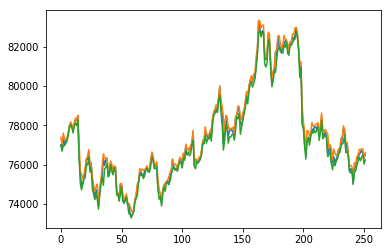

In [20]:
#getting close price
CLOSE = np.array(F_AD.loc[:252-1, [' CLOSE']])
plt.plot(CLOSE)

#getting volumes
VOL = np.array(F_AD.loc[:252-1, [' VOL']])
#plt.plot(VOL)

#getting OI
OI = np.array(F_AD.loc[:252-1, [' VOL']])
#plt.plot(OI)

#HIGH
HIGH = np.array(F_AD.loc[:252-1, [' HIGH']])
plt.plot(HIGH)

#LOW
LOW = np.array(F_AD.loc[:252-1, [' LOW']])
plt.plot(LOW)

#OPEN
OPEN = np.array(F_AD.loc[:252-1, [' OPEN']])
print(OPEN.shape)

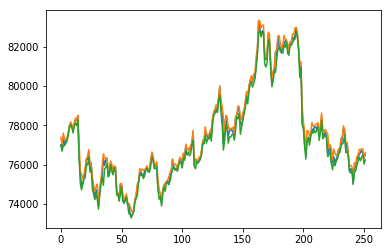

In [12]:
poly = PolynomialFeatures(degree=5)
X = poly.fit_transform(np.arange(252).reshape(-1, 1))
y = CLOSE[:]
vol_features = poly.fit_transform(VOL)
oi_features = poly.fit_transform(OI)
low_features = poly.fit_transform(LOW)
X_vol = np.append(X, vol_features, axis=1)
X_oi = np.append(X, oi_features, axis=1)
print(X_oi.shape)

(252, 12)


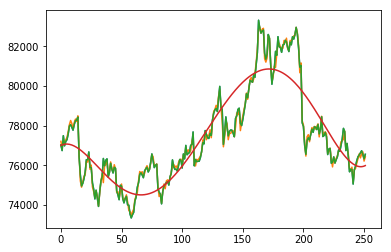

In [13]:
#fitting
reg = linear_model.LinearRegression()
a = np.append(vol_features,oi_features, axis=1)
a = np.append(a,low_features, axis=1)
reg.fit(low_features, y)
plt.plot(y)
#plt.plot(reg.predict(X))
plt.plot(reg.predict(low_features))

reg.fit(X,y)
plt.plot(y)
plt.plot(reg.predict(X))

In [14]:
reg.predict(poly.fit_transform(np.array([[252]])))

array([[76017.68852189]])

In [15]:
F_AD.loc[252, [' CLOSE']]

 CLOSE    76560.0
Name: 252, dtype: float64

In [34]:
#checking the code
market = 0
lookback=252


##predicting volume##
reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), VOL[:])
vol_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
#plt.plot(VOL)
#plt.plot(reg.predict(poly.fit_transform(np.arange(lookback).reshape(-1,1))))
##predicting open##
reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), OPEN[:])
open_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
#plt.plot(OPEN)
#plt.plot(reg.predict(poly.fit_transform(np.arange(lookback).reshape(-1,1))))

#use past volume and open data
X = np.append(OPEN,VOL, axis=1)
reg.fit(X, CLOSE[:])
x = np.append(open_predict,vol_predict, axis=1)
print(x.shape)
reg.predict(x)

(1, 2)


array([[75852.78738789]])

In [ ]:
class myStrategy(object):

    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):
        """ This system uses linear regression to allocate capital into the desired equities"""

        # Get parameters from setting
        nMarkets = len(settings['markets'])
        lookback = settings['lookback']
        dimension = settings['dimension']
        threshold = settings['threshold']

        pos = np.zeros(nMarkets, dtype=np.float)

        poly = PolynomialFeatures(degree=dimension)
        for market in range(nMarkets):
            reg = linear_model.LinearRegression()
            try:
                #predicting volume
                reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), VOL[:,market])
                vol_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
                #predicting open price
                reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), OPEN[:,market])
                open_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
                #predicting close price
                X = np.append(VOL[:,market], OPEN[:,market], axis=1)
                reg.fit(X,CLOSE[:,market])
                x = np.append(vol_predict,open_predict,axis=1)
                close_predict = reg.predict(x)
                
                trend = (close_predict - CLOSE[-1, market]) / CLOSE[-1, market]

                if abs(trend[0]) < threshold:
                    trend[0] = 0

                pos[market] = np.sign(trend)

            # for NaN data set position to 0
            except ValueError:
                pos[market] = .0

        return pos, settings


    def mySettings(self):
        """ Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD',
                               'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        settings['lookback'] = 252
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05

        settings['threshold'] = 0.05
        settings['dimension'] = 3

        return settings

In [ ]:
result = quantiacsToolbox.runts(myStrategy)

copying data from cache
Evaluating Trading System <class '__main__.myStrategy'>


/home/anshul/anaconda3/lib/python3.6/site-packages/quantiacsToolbox/quantiacsToolbox.py:881: RuntimeWarning: invalid value encountered in true_divide
  position = position / np.sum(abs(position))
